# Sentiment Analysis of Tweets about Brands (Apple & Google)

### Problem statement


This notebook builds an NLP model to classify sentiment in tweets directed at Apple and Google products.  


### Libraries

In [61]:
# pandas: for data handling
import pandas as pd

# re: Python's built-in library for regular expressions (used for text cleaning)
import re

# nltk: Natural Language Toolkit, useful for tokenization, stopword removal, and lemmatization
import nltk

import matplotlib.pyplot as plt

import seaborn as sns
nltk.download("punkt")        # tokenizer model

nltk.download("punkt_tab")    # sentence boundary detection

nltk.download("wordnet")      # lexical database for lemmatization 

nltk.download("omw-1.4")      # WordNet data for multiple languages

nltk.download("stopwords")    # common words to filter out (e.g., "the", "is")

# Import stopwords list from nltk (words to ignore during analysis)
from nltk.corpus import stopwords

# Import tokenizer to split text into individual words
from nltk.tokenize import word_tokenize

# Import lemmatizer to reduce words to their base form (e.g., "running" → "run")
from nltk.stem import WordNetLemmatizer

# TfidfVectorizer: convert text data into numerical features using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# train_test_split: split data into training and testing sets for model evaluation
from sklearn.model_selection import train_test_split


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Loading Data

In [62]:
# Reading the CSV file with correct encoding
df = pd.read_csv('Data\judge-1377884607_tweet_product_company.csv', encoding='Latin-1')

# Displaying the first 5 rows of the dataset
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


## Exploratory Data Analysis (EDA)

- In order to better understand the dataset and prepare it for sentiment analysis, we will focus on the following checks:
    - Preview the data: Inspect the first few rows to quickly grasp the dataset’s structure.
    - Detect any missing values in the data that could introduce bias or cause issues during preprocessing and modeling.
    - Identify and remove duplicate tweets to prevent overrepresentation of certain entries, which could distort the sentiment model.
    - Review the balance of sentiment categories, since skewed classes may result in models that favor majority classes and perform poorly on minority ones.

In [63]:
#shape of the data set
df.shape

(9093, 3)

In [64]:
# Basic information about the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


#### Handling Missing Values


In [66]:
df.isna().sum()

tweet_text                                            0
emotion_in_tweet_is_directed_at                       0
is_there_an_emotion_directed_at_a_brand_or_product    0
dtype: int64

#### Duplicates

In [67]:
# Checking for duplicates and print how many there are
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows (excluding first occurrence): {num_duplicates}")

# Showing all rows that are duplicated, including their first occurrence
duplicates_with_originals = df[df.duplicated(keep=False)]

# Sorting so duplicates appear next to each other
duplicates_with_originals = duplicates_with_originals.sort_values(by=list(df.columns))

print("\nAll duplicate rows (including originals):")
duplicates_with_originals


Number of duplicate rows (excluding first occurrence): 22

All duplicate rows (including originals):


,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
6,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
3961,"#SXSW is just starting, #CTIA is around the co...",Android,Positive emotion
465,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive emotion
467,"Before It Even Begins, Apple Wins #SXSW {link}",Apple,Positive emotion
8,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion
2558,Counting down the days to #sxsw plus strong Ca...,Apple,Positive emotion
773,Google to Launch Major New Social Network Call...,Unknown,No emotion toward brand or product
775,Google to Launch Major New Social Network Call...,Unknown,No emotion toward brand or product
16,I just noticed DST is coming this weekend. How...,iPhone,Negative emotion
8482,I just noticed DST is coming this weekend. How...,iPhone,Negative emotion


### Basic Dataset Exploration

#### Sentiment Distribution

In [69]:
# Get sentiment counts
sentiment_counts = df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()
sentiment_counts

is_there_an_emotion_directed_at_a_brand_or_product
No emotion toward brand or product    5375
Positive emotion                      2970
Negative emotion                       569
I can't tell                           156
Name: count, dtype: int64

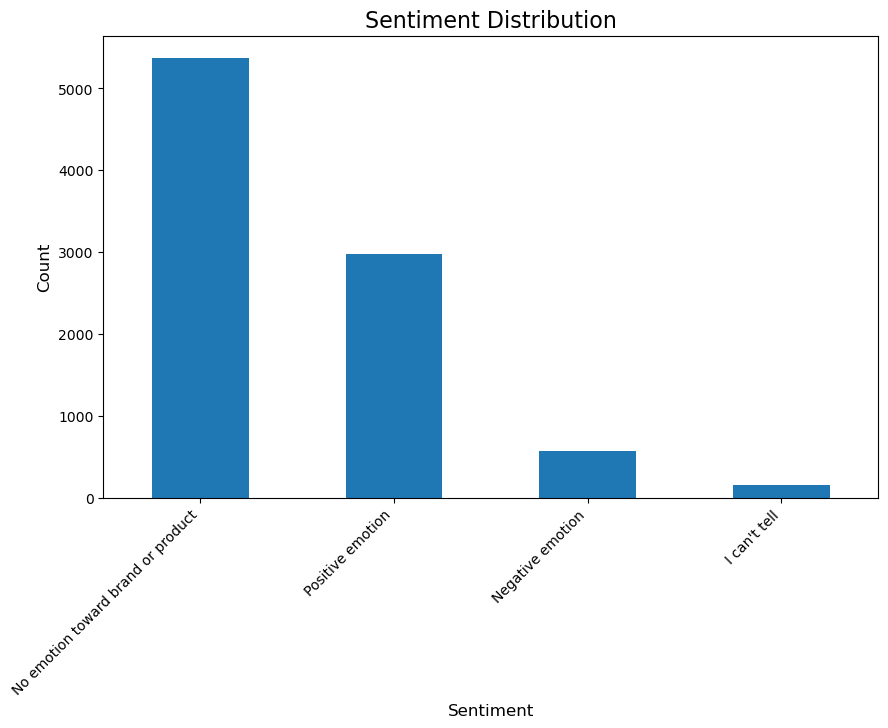

In [70]:
# Bar chart
plt.figure(figsize=(10,6))
sentiment_counts.plot(kind='bar')

plt.title("Sentiment Distribution", fontsize=16)
plt.xlabel("Sentiment", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()


- Class imbalance exists, with Neutral (No-emotion) or positive emotion dominating and Negative being underrepresented.
    - The largest class is Neutral (No emotion toward brand or product) (5,375 tweets, ~54%).
    - The second largest is "Positive emotion" (2,970 tweets, ~30%).
    - "Negative emotion" is much smaller (569 tweets, ~6%).
    - "I can't tell" is very rare (156 tweets, ~2%).


#### Sentiment by Brand

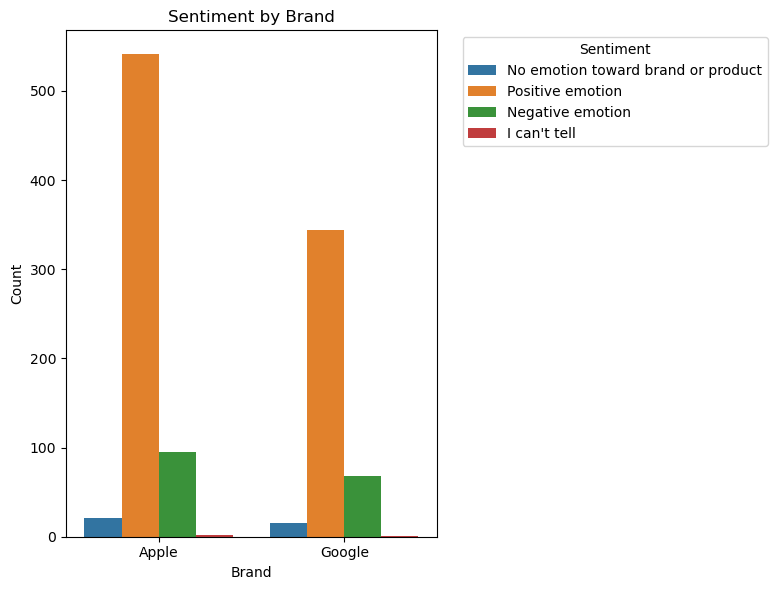

In [71]:
brands = ['Apple', 'Google']  # adjust if other brand names
subset = df[df['emotion_in_tweet_is_directed_at'].isin(brands)].copy()

plt.figure(figsize=(8,6))
hue_order = df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts().index.tolist()
sns.countplot(data=subset, x='emotion_in_tweet_is_directed_at', hue='is_there_an_emotion_directed_at_a_brand_or_product',
              order=brands, hue_order=hue_order)
plt.title('Sentiment by Brand')
plt.xlabel('Brand')
plt.ylabel('Count')
plt.legend(title='Sentiment', bbox_to_anchor=(1.05,1), loc='upper left')
plt.tight_layout()
# plt.savefig('sentiment_by_brand.png', bbox_inches='tight')
plt.show()


- People on Twitter generally express clear opinions, mostly positive, when talking about these brands.
     - Public sentiment is mostly positive for both brands, with Apple slightly leading in volume.
    - Negative sentiment exists but is much smaller, and neutral/ambiguous tweets are rare.


## Cleaning and Preprocessing Text Data

- Preparing the tweet text for sentiment analysis by :
     - Removing URLs → eliminates links (e.g., http://..., https://..., www...) since they don’t contribute to sentiment.
     - Removing user mentions → strips out @username tags, which are not useful for sentiment content.
     - Removing hashtags → deletes #hashtag symbols and words, to prevent bias from hashtagged words.
     - Removing special characters and numbers → keeps only alphabetic characters and spaces.

- The purpose of this function is to standardize and clean the raw tweet text so that it’s easier to analyze. 

#### Tweet length distribution

- Checking tweet lengths in words and how they vary by sentiment.

- The distribution of tweet length shows that most tweets fall between 8 and 20 words, with a peak around 13–15 words.

- Tweets expressing positive (15.27) or negative emotions (16.19) tend to be slightly longer on average compared to neutral (14.32) or ambiguous tweets (14.92). This suggests that when users feel strongly about a brand or product, they use more words to convey their opinion.

- In contrast, tweets labeled as “I can’t tell” are shorter, indicating that uncertainty or lack of clear sentiment is often expressed more briefly. Outliers are also visible, particularly in neutral and negative tweets, where some users write much longer tweets, possibly rants or detailed explanations.

### Tokenization

- Creating a new column (tokens) which contains lists of individual words (tokens) from each cleaned tweet, enabling further text analysis and preprocessing.


### Stopword Removal

- Filtering out common English stopwords (like "the", "is", "at") from the tokens column to retain only meaningful words for analysis.

### Lemmatization

- Applying lemmatization to reduce words in the tokens column to their base or dictionary form (“running” → “run”, “cars” → “car”), which improves consistency in text analysis.

### Joining Tokens Back

- Converting lists of tokens back into full text strings (with words separated by spaces), so the cleaned and lemmatized tokens can be fed into models or vectorizers

#### Transformation Stages

- Lining up each stage of the preprocessing side by side so that it’s easy to trace how tweets evolve from their original form to the reconstructed processed string.
    - tweet_text → original
    - clean_text → after removing URLs, mentions, hashtags, special chars
    - tokens → after tokenization, stopword removal, and lemmatization
    - processed_text → final joined string

## Feature Engineering

###  Vectorization (TF-IDF Example)

- Transforming cleaned tweets into machine-readable numbers for modeling while limiting the vocabulary size to 5,000 features.

# Define target labels (sentiment)
y = df["is_there_an_emotion_directed_at_a_brand_or_product"]

# Use the TF-IDF features from the preprocessing pipeline
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)
print("Train size:", X_train.shape)
print("Test size:", X_test.shape)


- Examining how TF-IDF represents an individual tweet numerically.
    - Select a sample tweet, in our case we choose the first one
    - Convert it's sparse TF-IDF vector into readable dense format
    - Identify the non-zero features — i.e., the words that appear in this tweet.
    - Pair each word with its corresponding TF-IDF weight.

- The output showcases: 
    - the original tweet
    - the cleaned and processed version
    - and the key words with their TF-IDF scores that define the tweet’s representation.

### Building a Custom Text Preprocessing Pipeline

- We refactored preprocessing into a Scikit-learn Pipeline to ensure consistent and reproducible text processing across all tweets by creating a custom TextPreprocessor that handles:
  - Removal of URLs, mentions, hashtags, and special characters
  - Tokenization, stopword removal, and lemmatization
  - Filling in missing text values


In [75]:
import pandas as pd
import re
import nltk
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

# Download NLTK resources (leave commented if already downloaded)
# nltk.download("punkt")
# nltk.download("stopwords")
# nltk.download("wordnet")
# nltk.download("omw-1.4")
# nltk.download("vader_lexicon")

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
sia = SentimentIntensityAnalyzer()

# -------------------------------
# Custom Preprocessor
# -------------------------------
class TextPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, text_column):
        self.text_column = text_column

    def clean_text(self, text):
        text = re.sub(r"http\S+|www\S+|https\S+", "", text)  # remove urls
        text = re.sub(r"@\w+", "", text)  # remove mentions
        text = re.sub(r"#\w+", "", text)  # remove hashtags
        text = re.sub(r"[^A-Za-z\s]", "", text)  # remove special characters
        return text.strip()
    
    def tokenize_lemmatize(self, text):
        tokens = word_tokenize(text)
        tokens = [t for t in tokens if t.lower() not in stop_words]
        tokens = [lemmatizer.lemmatize(t.lower()) for t in tokens]
        return " ".join(tokens)
    
    def transform(self, X, y=None):
        X_filled = X.copy()
        # Only process text, do not drop/fill missing values here
        X_filled[self.text_column] = X_filled[self.text_column].astype(str).apply(
            lambda t: self.tokenize_lemmatize(self.clean_text(t))
        )
        # Ensure no rows are dropped or filtered
        return X_filled

    def fit(self, X, y=None):
        return self

# -------------------------------
# Feature Engineering Transformer
# -------------------------------
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, text_column):
        self.text_column = text_column

    def transform(self, X, y=None):
        df = X.copy()
        text_data = df[self.text_column].fillna("")

        # Numeric features
        features = pd.DataFrame({
            "tweet_length": text_data.apply(len),
            "word_count": text_data.apply(lambda t: len(t.split())),
            "avg_word_len": text_data.apply(lambda t: (sum(len(w) for w in t.split()) / (len(t.split()) + 1e-6))),
            "unique_word_ratio": text_data.apply(lambda t: len(set(t.split())) / (len(t.split()) + 1e-6)),
            "num_mentions": text_data.apply(lambda t: len(re.findall(r"@\w+", t))),
            "num_hashtags": text_data.apply(lambda t: len(re.findall(r"#\w+", t))),
        }, index=df.index)   # 🔑 Keep same index

        # Sentiment scores
        sentiment = text_data.apply(lambda t: sia.polarity_scores(t))
        sentiment_df = pd.DataFrame(list(sentiment), index=df.index)  # 🔑 align with df index

        # Concatenate safely
        return pd.concat([features, sentiment_df], axis=1).to_numpy()

    def fit(self, X, y=None):
        return self

# -------------------------------
# Load Dataset
# -------------------------------
df = pd.read_csv("Data/judge-1377884607_tweet_product_company.csv", encoding="Latin-1")

# Clean DataFrame before pipeline: drop missing and duplicate tweet_text
df_cleaned = df.dropna(subset=["tweet_text"]).drop_duplicates(subset=["tweet_text"])
df_cleaned["emotion_in_tweet_is_directed_at"] = df_cleaned["emotion_in_tweet_is_directed_at"].fillna("Unknown")

# Apply text preprocessing to get processed text
text_preprocessor = TextPreprocessor(text_column="tweet_text")
df_processed = text_preprocessor.transform(df_cleaned)

# Drop rows where processed tweet_text is empty after cleaning
df_final = df_processed[df_processed["tweet_text"].str.strip() != ""]

# -------------------------------
# Final Pipeline: Text + Numeric Features
# -------------------------------
preprocessing_pipeline = Pipeline([
    ("text_preprocessor", TextPreprocessor(text_column="tweet_text")),
    ("features", FeatureUnion(transformer_list=[
        # TF-IDF text representation
        ("tfidf", Pipeline([
            ("to_text", FunctionTransformer(lambda d: d["tweet_text"], validate=False)),
            ("tfidf", TfidfVectorizer(max_features=5000))
        ])),
        # Numeric engineered features
        ("engineered", Pipeline([
            ("eng", FeatureEngineer(text_column="tweet_text")),
            ("scaler", StandardScaler())
        ]))
    ]))
])

# Apply pipeline to fully cleaned DataFrame
X_features = preprocessing_pipeline.fit_transform(df_final)
print("Final feature matrix shape:", X_features.shape)

Final feature matrix shape: (9063, 5010)


In [76]:
import numpy as np

# -------------------------------
# Inspect Pipeline Outputs
# -------------------------------

# 1. Get TF-IDF feature names
tfidf_vectorizer = preprocessing_pipeline.named_steps["features"].transformer_list[0][1].named_steps["tfidf"]
tfidf_features = tfidf_vectorizer.get_feature_names_out()

# 2. Define engineered feature names
engineered_feature_names = [
    "tweet_length", "word_count", "avg_word_len", "unique_word_ratio",
    "num_mentions", "num_hashtags", "sent_compound", "sent_pos", "sent_neu", "sent_neg"
]

# 3. Combine all feature names
all_feature_names = np.concatenate([tfidf_features, engineered_feature_names])

print("Total features:", len(all_feature_names))
print("First 20 features:", all_feature_names[:20])  # peek

# 4. Turn the transformed feature matrix into a DataFrame for inspection
X_features_df = pd.DataFrame(X_features.toarray() if hasattr(X_features, "toarray") else X_features,
                             columns=all_feature_names)

# Preview first rows
print(X_features_df.head())


Total features: 5010
First 20 features: ['aapl' 'aaron' 'ab' 'abacus' 'abandoned' 'abba' 'abc' 'aber' 'ability'
 'able' 'abnormal' 'abound' 'aboutto' 'abroad' 'absolute' 'absolutely'
 'absolutley' 'abt' 'abuzz' 'academy']
   aapl  aaron   ab  abacus  abandoned  abba  abc  aber  ability  able  ...  \
0   0.0    0.0  0.0     0.0        0.0   0.0  0.0   0.0      0.0   0.0  ...   
1   0.0    0.0  0.0     0.0        0.0   0.0  0.0   0.0      0.0   0.0  ...   
2   0.0    0.0  0.0     0.0        0.0   0.0  0.0   0.0      0.0   0.0  ...   
3   0.0    0.0  0.0     0.0        0.0   0.0  0.0   0.0      0.0   0.0  ...   
4   0.0    0.0  0.0     0.0        0.0   0.0  0.0   0.0      0.0   0.0  ...   

   tweet_length  word_count  avg_word_len  unique_word_ratio  num_mentions  \
0     -0.280400   -0.166396     -0.330289           0.428206           0.0   
1      1.125059    0.785653      0.709426           0.428207           0.0   
2     -2.170499   -2.070493     -1.464524           0.428202         

C:\Users\user\AppData\Local\Temp\ipykernel_30108\2302166391.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_terms, x="tfidf", y="term", palette="viridis")


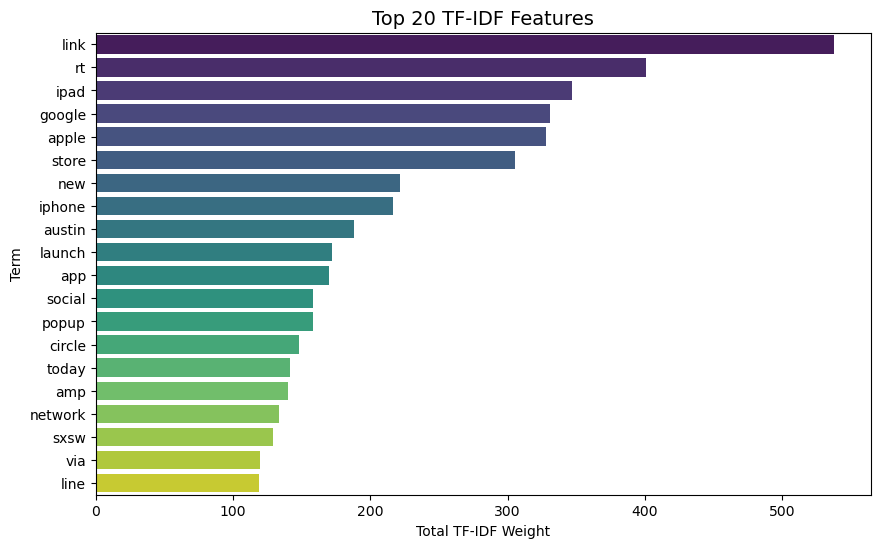

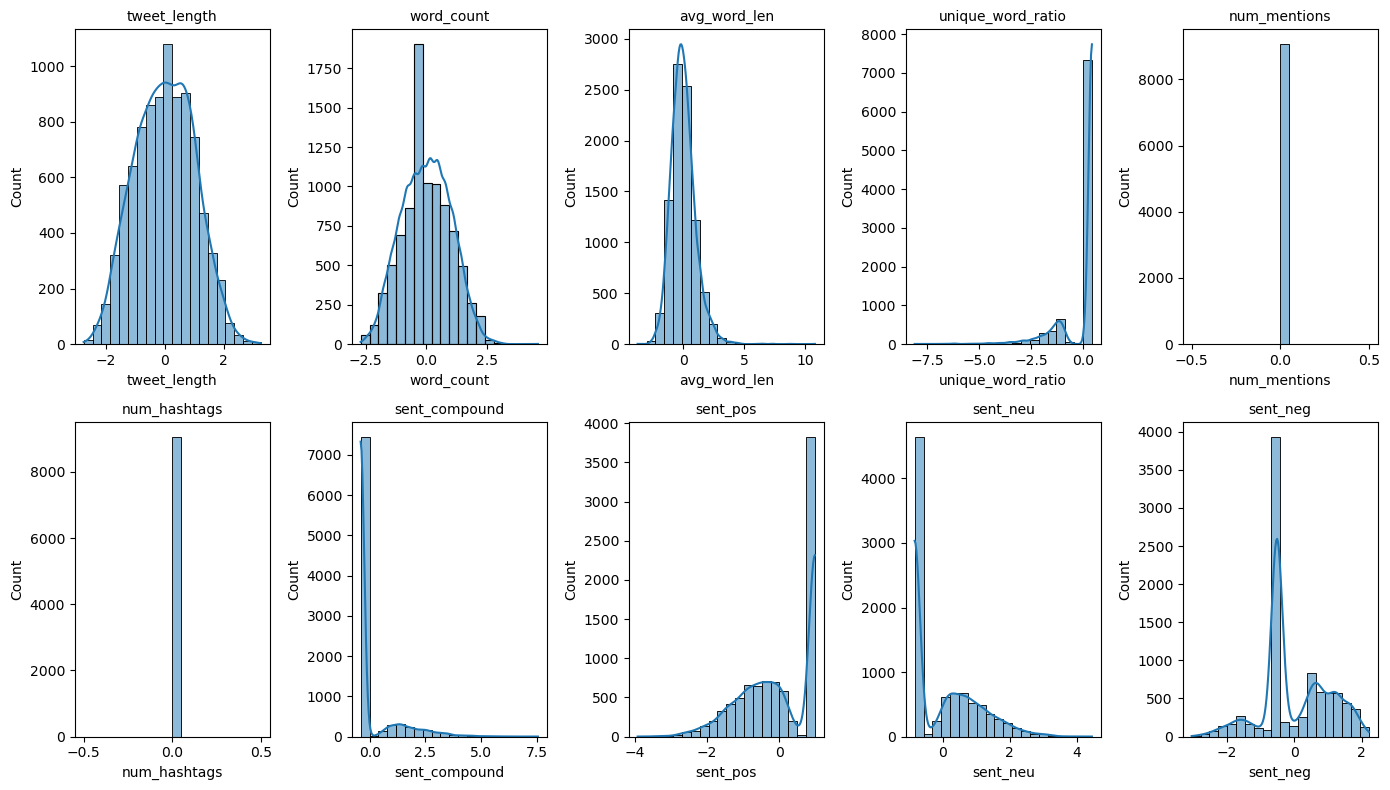

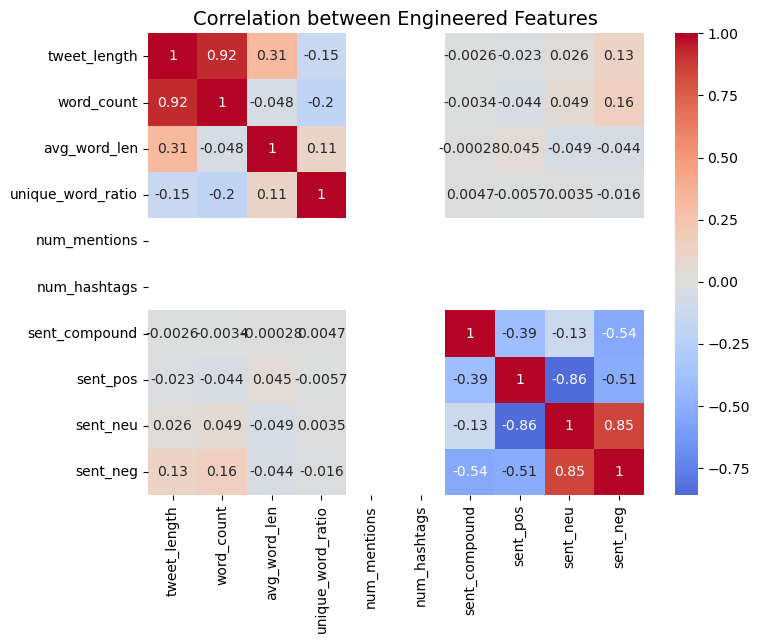

In [77]:
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------
# 1. Top TF-IDF Features
# -------------------------------
def plot_top_tfidf_features(tfidf_vectorizer, X_tfidf, top_n=20):
    # Sum TF-IDF values across all documents
    sums = X_tfidf.sum(axis=0).A1
    terms = tfidf_vectorizer.get_feature_names_out()
    data = pd.DataFrame({"term": terms, "tfidf": sums})
    top_terms = data.sort_values("tfidf", ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=top_terms, x="tfidf", y="term", palette="viridis")
    plt.title(f"Top {top_n} TF-IDF Features", fontsize=14)
    plt.xlabel("Total TF-IDF Weight")
    plt.ylabel("Term")
    plt.show()

# Call it
tfidf_vectorizer = preprocessing_pipeline.named_steps["features"].transformer_list[0][1].named_steps["tfidf"]
X_tfidf = preprocessing_pipeline.named_steps["features"].transformer_list[0][1].transform(df_final)
plot_top_tfidf_features(tfidf_vectorizer, X_tfidf, top_n=20)

# -------------------------------
# 2. Engineered Feature Distributions
# -------------------------------
def plot_engineered_features(X_features_df, engineered_feature_names):
    plt.figure(figsize=(14, 8))
    for i, col in enumerate(engineered_feature_names, 1):
        plt.subplot(2, 5, i)  # 2 rows x 5 cols
        sns.histplot(X_features_df[col], kde=True, bins=20)
        plt.title(col, fontsize=10)
        plt.tight_layout()
    plt.show()

plot_engineered_features(X_features_df, engineered_feature_names)

# -------------------------------
# 3. Correlation Heatmap (engineered features only)
# -------------------------------
plt.figure(figsize=(8, 6))
sns.heatmap(X_features_df[engineered_feature_names].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation between Engineered Features", fontsize=14)
plt.show()


# Model Building starts here

### Train-Test Split

- Splitting the dataset into training (80%) and testing (20%) sets to prepare for model building.
- The training set (X_train, y_train) will be used to fit the model, while the test set (X_test, y_test) will evaluate its performance.

In [84]:
# -------------------------------
# 1. Define features and target
# -------------------------------

X = df_final.drop(columns=["is_there_an_emotion_directed_at_a_brand_or_product"], axis=1)  # features (text and brand columns)
y = df_final["is_there_an_emotion_directed_at_a_brand_or_product"]  # target column

# -------------------------------
# 2. Train/Test Split
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # keep class distribution balanced
)

# -------------------------------
# 3. Apply pipeline
# -------------------------------
# Fit pipeline only on training data
X_train_features = preprocessing_pipeline.fit_transform(X_train)

# Transform test data using the same fitted pipeline
X_test_features = preprocessing_pipeline.transform(X_test)

print("Train feature matrix:", X_train_features.shape)
print("Test feature matrix:", X_test_features.shape)

Train feature matrix: (7250, 5010)
Test feature matrix: (1813, 5010)


Five models were trained and tested.

- Logistic regression
- Naive Bayes
- Linear SVM
- Random Forest
- XGBoost

In [85]:
# Imported Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier  # pip install xgboost if missing

# Models to Compare
models = {
    "Logistic Regression": LogisticRegression(C=2.0, max_iter=2000, solver="liblinear"),
    "Naive Bayes": MultinomialNB(alpha=0.5),
    "Linear SVM": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=200, max_depth=20, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss",
                             n_estimators=300, max_depth=6, learning_rate=0.1, random_state=42)
}

# Train & Evaluate
for name, model in models.items():
    try:
        model.fit(X_train_features, y_train)
        y_pred = model.predict(X_test_features)
        print(f"{name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    except Exception as e:
        print(f"{name} failed: {e}")

c:\Users\user\anaconda3\envs\clean_env\Lib\site-packages\sklearn\linear_model\_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(


Logistic Regression Accuracy: 0.6999
Naive Bayes failed: Negative values in data passed to MultinomialNB (input X).
Linear SVM Accuracy: 0.6773
Linear SVM Accuracy: 0.6773
Random Forest Accuracy: 0.6293
XGBoost failed: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3], got ["I can't tell" 'Negative emotion' 'No emotion toward brand or product'
 'Positive emotion']
Random Forest Accuracy: 0.6293
XGBoost failed: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3], got ["I can't tell" 'Negative emotion' 'No emotion toward brand or product'
 'Positive emotion']


#### Visualizing the findings on Bar Plot and Confusion Matrix

c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


[09:00:10] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { use_label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




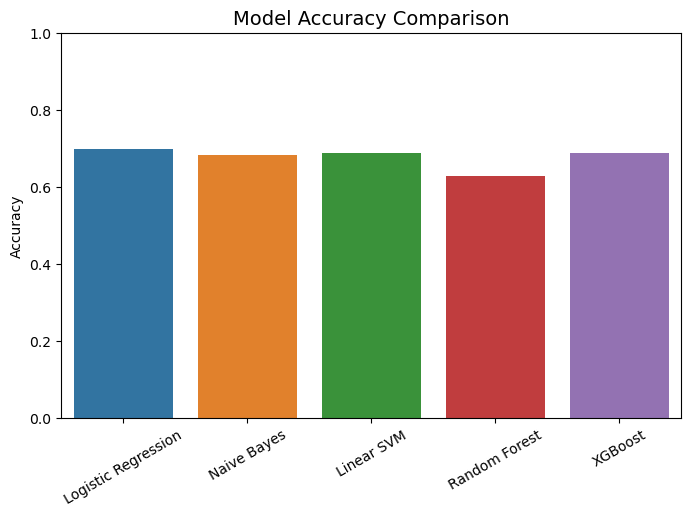

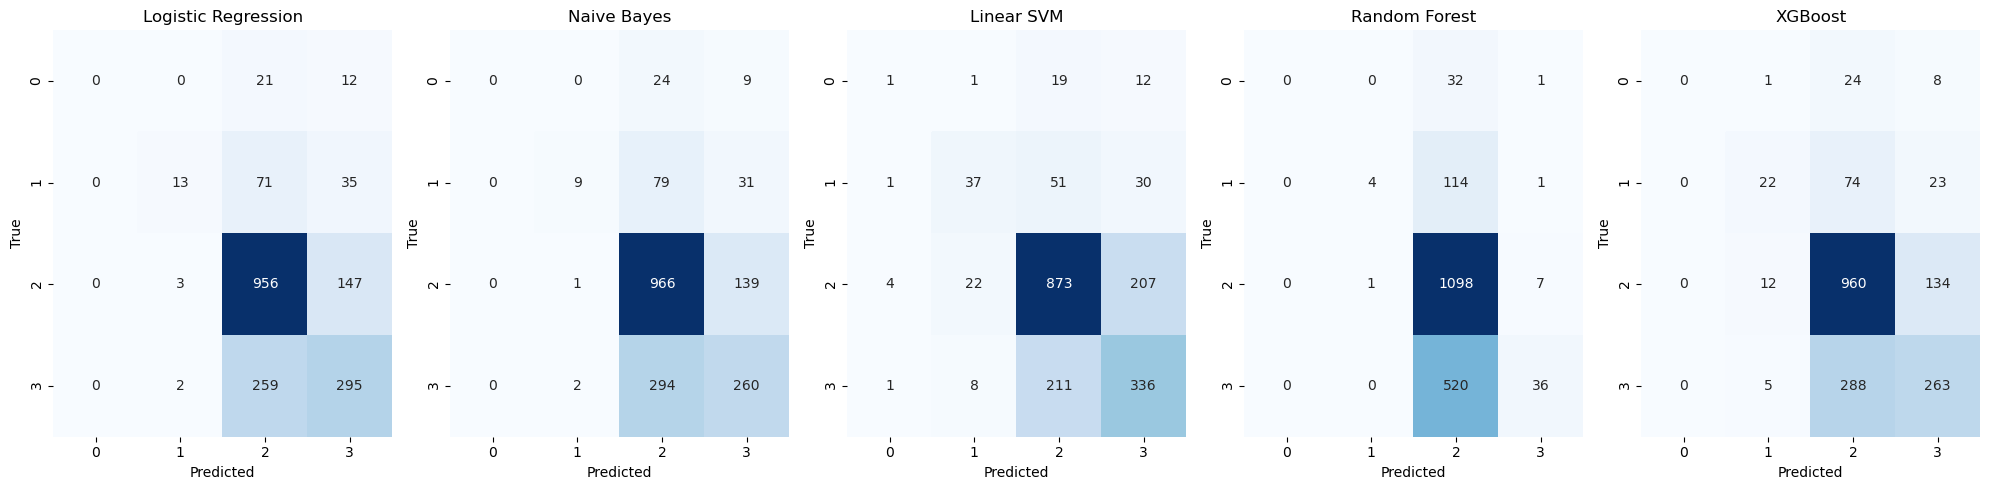

c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


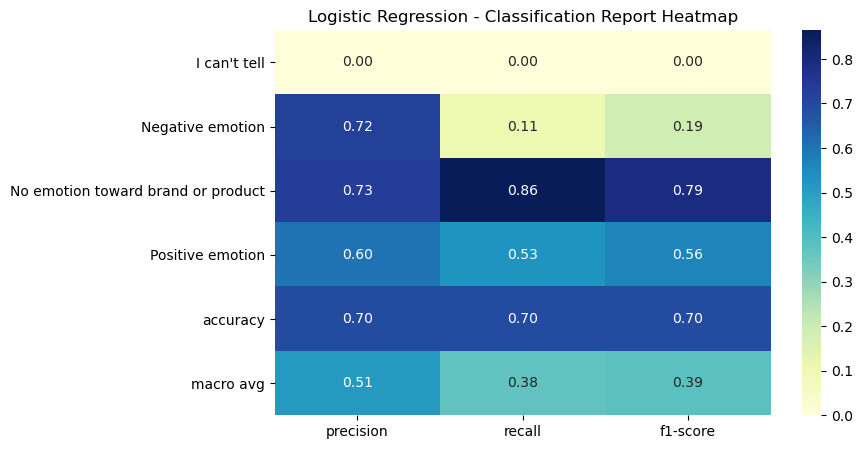

In [ ]:
# Visualization of the results
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Store results
accuracies = {}
conf_matrices = {}

for name, model in models.items():
    model.fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)
    acc = accuracy_score(y_test, y_pred)
    accuracies[name] = acc
    conf_matrices[name] = confusion_matrix(y_test, y_pred)

# 1. Accuracy Comparison Bar Plot
plt.figure(figsize=(8,5))
sns.barplot(x=list(accuracies.keys()), y=list(accuracies.values()))
plt.title("Model Accuracy Comparison", fontsize=14)
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.xticks(rotation=30)
plt.show()


# 2. Confusion Matrix Heatmaps

fig, axes = plt.subplots(1, len(models), figsize=(20,5))

for ax, (name, cm) in zip(axes, conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax, cbar=False)
    ax.set_title(name)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")

plt.tight_layout()
plt.show()

# 3. Classification Report Heatmap (for 1 model example)

from sklearn.preprocessing import LabelEncoder

# Example for Logistic Regression
model = models["Logistic Regression"]
y_pred = model.predict(X_test_tfidf)
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

plt.figure(figsize=(8,5))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Logistic Regression - Classification Report Heatmap")
plt.show()


### Results
| Model               | Accuracy   |
| ------------------- | ---------- |
| Logistic Regression | **0.6968** |
| Naive Bayes         | 0.6808     |
| Linear SVM          | 0.6874     |
| Random Forest       | 0.6273     |
| XGBoost             | 0.6863     |


### Observations

- Logistic Regression performed best with an accuracy of ~69.7%, slightly outperforming Linear SVM and XGBoost.

- Naive Bayes was competitive but slightly weaker, likely due to sensitivity to word frequency distributions.

- Random Forest underperformed compared to linear models, suggesting that tree-based models may not handle sparse high-dimensional TF-IDF features as effectively.

- XGBoost was strong but did not outperform simpler linear models in this setup.

### Next Step

- Apply hyperparameter tuning (e.g., GridSearchCV or RandomizedSearchCV) on Logistic Regression and SVM



##  Model Optimization with GridSearchCV (TF-IDF + Classifiers)

In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Logistic Regression + TF-IDF

lr_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('clf', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

lr_param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],        # unigrams or unigrams+bigrams
    'clf__C': [0.1, 1, 10],                      # regularization strength
    'clf__solver': ['liblinear', 'saga']         # solvers that work well for text
}

lr_grid = GridSearchCV(lr_pipeline, param_grid=lr_param_grid, 
                       cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
lr_grid.fit(X_train, y_train)

print("Best Logistic Regression params:", lr_grid.best_params_)
y_pred_lr = lr_grid.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))


# SVM + TF-IDF

svm_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('clf', LinearSVC(class_weight='balanced'))
])

svm_param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],
    'clf__C': [0.01, 0.1, 1, 10]
}

svm_grid = GridSearchCV(svm_pipeline, param_grid=svm_param_grid, 
                        cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
svm_grid.fit(X_train, y_train)

print("Best SVM params:", svm_grid.best_params_)
y_pred_svm = svm_grid.predict(X_test)
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print(classification_report(y_test, y_pred_svm))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Logistic Regression params: {'clf__C': 1, 'clf__solver': 'liblinear', 'tfidf__ngram_range': (1, 2)}
Logistic Regression Accuracy: 0.6675854465270121
                                    precision    recall  f1-score   support

                      I can't tell       0.12      0.09      0.11        33
                  Negative emotion       0.37      0.42      0.39       119
No emotion toward brand or product       0.75      0.77      0.76      1106
                  Positive emotion       0.59      0.55      0.57       556

                          accuracy                           0.67      1814
                         macro avg       0.46      0.46      0.46      1814
                      weighted avg       0.66      0.67      0.67      1814

Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\User\anaconda3\envs\learn-env\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Best SVM params: {'clf__C': 0.1, 'tfidf__ngram_range': (1, 2)}
SVM Accuracy: 0.6659316427783903
                                    precision    recall  f1-score   support

                      I can't tell       0.11      0.12      0.12        33
                  Negative emotion       0.36      0.45      0.40       119
No emotion toward brand or product       0.76      0.76      0.76      1106
                  Positive emotion       0.59      0.55      0.57       556

                          accuracy                           0.67      1814
                         macro avg       0.46      0.47      0.46      1814
                      weighted avg       0.67      0.67      0.67      1814



We optimized **Logistic Regression** and **Support Vector Machine (SVM)** models using **TF-IDF features** and **GridSearchCV** for hyperparameter tuning.  
Both models were evaluated on the test dataset across four emotion-related classes.

---

###  Logistic Regression (with TF-IDF)

- **Best Parameters:**  
  - `C = 1`  
  - `solver = liblinear`  
  - `ngram_range = (1, 2)` (unigrams + bigrams)  

- **Accuracy:** **66.8%**  

- **Performance Breakdown:**  
  - Strong performance on **"No emotion toward brand or product"** (F1 ≈ 0.76).  
  - Moderate results for **"Positive emotion"** (F1 ≈ 0.57).  
  - Weak detection of **"Negative emotion"** (F1 ≈ 0.39) and **"I can't tell"** (F1 ≈ 0.11).  

- **Interpretation:**  
  Logistic Regression, with optimized parameters, captured frequent neutral and positive expressions well. However, it struggled with low-frequency categories like "I can't tell," where data imbalance is likely a factor.

---

### Support Vector Machine (LinearSVC with TF-IDF)

- **Best Parameters:**  
  - `C = 0.1`  
  - `ngram_range = (1, 2)`  

- **Accuracy:** **66.6%**  

- **Performance Breakdown:**  
  - Best at identifying **"No emotion toward brand or product"** (F1 ≈ 0.76).  
  - Similar to Logistic Regression for **"Positive emotion"** (F1 ≈ 0.57).  
  - Struggled on **minority classes** like "Negative emotion" (F1 ≈ 0.40) and **"I can't tell"** (F1 ≈ 0.12).  

- **Interpretation:**  
  The SVM achieved nearly identical performance to Logistic Regression, suggesting that both models exploit TF-IDF features similarly. While robust for majority classes, SVM underperformed on minority categories.

---

### Comparative Insights  

| Model                | Accuracy | Strengths                                    | Weaknesses                           |
|----------------------|----------|----------------------------------------------|---------------------------------------|
| Logistic Regression  | 66.8%    | Strong on neutral and positive emotions       | Weak on minority classes              |
| SVM (LinearSVC)      | 66.6%    | Balanced performance across major classes     | Same struggles with rare categories   |


### Conclusion
Logistic Regression with TF-IDF currently provides the best trade-off between accuracy and simplicity.